### 显示高斯

In [17]:
import numpy as np
import math
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [18]:
def gaussian_2d(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h


def draw_gaussian(heatmap, center, radius, k=1):
    radius = math.ceil(radius)
    diameter = 2 * radius + 1
    gaussian = gaussian_2d((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap


In [19]:
heatmap = np.zeros((1, 1, 100, 100), np.float32)
print(heatmap)

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]


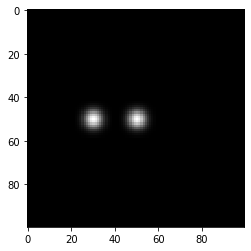

In [50]:
draw_gaussian(heatmap[0, 0], (50, 50), 8)
draw_gaussian(heatmap[0, 0], (30, 50), 8)
plt.imshow(heatmap[0, 0], cmap='gray')

In [52]:
torch_hm = torch.tensor(heatmap)
torch_hm.shape

torch.Size([1, 1, 100, 100])

In [53]:
pool = F.max_pool2d(torch_hm, (3, 3), stride=1, padding=1)
pool.shape

torch.Size([1, 1, 100, 100])

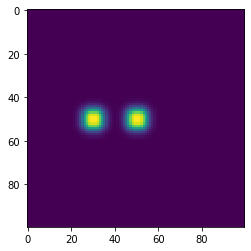

In [54]:
plt.imshow(pool[0, 0].data.numpy())

torch.Size([1, 1, 100, 100])

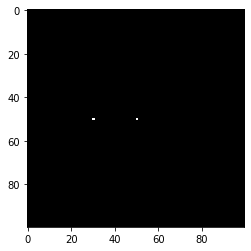

In [55]:
mask = (pool== torch_hm).float() * torch_hm
plt.imshow(mask[0, 0], cmap="gray")
mask.shape

In [56]:
mask.shape[3]

100

In [57]:
view_mask = mask.view(1, -1)
view_mask.shape

torch.Size([1, 10000])

In [69]:
scores, indices = view_mask.topk(10)

In [70]:
scores.shape

torch.Size([1, 10])

In [71]:
scores.squeeze()

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [72]:
indices

tensor([[5050, 5030,    8,    4,    9,    7,    3,    1,    5,    0]])

In [73]:
for score, indice in zip(scores.squeeze().data.numpy(), indices.squeeze().data.numpy()):
    if score < 0.1:
        break
    cy = indice // mask.shape[3]
    cx = indice % mask.shape[3]
    print(score, indice, cx, cy)



1.0 5050 50 50
1.0 5030 30 50
